In [7]:
import pandas as pd
df = pd.read_csv('Data/OUTPUT_cleandata/df_dist.csv').drop(columns=['Unnamed: 0', 'block', 'lot', 'block_pluto', 'lot_pluto'])
df.head()

,address,zipcode,units_residential,units_commercial,saledate,bldg_age_at_sale_calc,log_saleprice,bct2020,schooldist,council,...,longitude,bin_ltdheight,bin_splitzone,bin_histdist,bin_landmark,far_calc,dist_park,dist_subway,dist_hospital,dist_school
0,738 EAST 6TH STREET,10009.0,11.0,0.0,2017-04-03,117.0,15.137266,1002601.0,1.0,2.0,...,-73.977946,0.0,1.0,0.0,0.0,3.716409,0.000879,0.009050,0.007082,0.001207
1,27 AVENUE C,10009.0,24.0,1.0,2017-07-11,107.0,15.470877,1002202.0,1.0,2.0,...,-73.981031,0.0,1.0,0.0,0.0,3.758491,0.000644,0.007157,0.005513,0.002245
2,153 AVENUE B,10009.0,5.0,0.0,2017-07-19,117.0,15.706361,1002800.0,1.0,2.0,...,-73.979857,0.0,1.0,0.0,0.0,3.943662,0.000317,0.004768,0.010503,0.001740
3,193 EAST 4TH STREET,10009.0,11.0,1.0,2017-11-13,117.0,15.853479,1003200.0,1.0,2.0,...,-73.984223,0.0,1.0,0.0,0.0,3.368928,0.001198,0.005776,0.009023,0.001944
4,"327 EAST 3 STREET, 1C",10009.0,0.0,0.0,2017-03-10,97.0,13.120361,1002601.0,1.0,2.0,...,-73.978423,0.0,1.0,0.0,0.0,5.418462,0.000262,0.009351,0.005194,0.001071


In [8]:
df.columns

df = df.drop(columns=['schooldist', 'council', 'policeprct', 'healthcenterdistrict', 'sanitdistrict'])

In [9]:
df = df.drop(columns=['address'])

In [10]:
df.columns.sort_values()

Index(['bct2020', 'bin_histdist', 'bin_landmark', 'bin_ltdheight',
       'bin_splitzone', 'bldg_age_at_sale_calc', 'comarea', 'dist_hospital',
       'dist_park', 'dist_school', 'dist_subway', 'factryarea', 'far_calc',
       'garagearea', 'healtharea', 'latitude', 'log_saleprice', 'longitude',
       'numbldgs', 'numfloors', 'officearea', 'otherarea', 'resarea',
       'retailarea', 'saledate', 'strgearea', 'units_commercial',
       'units_residential', 'yearalter1', 'yearalter2', 'yearbuilt',
       'zipcode'],
      dtype='object')

# Models

### Sort chronologically, train test split

In [11]:
#train test split

#sort values by date
df = df.sort_values('saledate')
df = df.drop(columns=['saledate'])

# drop sale price

#subset into X and y
X = df.drop('log_saleprice', axis=1)
y = df['log_saleprice']

#split into train test split
train_size = round(len(df)*0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(49809, 30)
(49809,)
(12452, 30)
(12452,)


## Run models

### RF preprocessor, full model

In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

numeric_features_full = X_train.select_dtypes([np.number]).columns.tolist()
categorical_features_full = X_train.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

preprocessor_full_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_full),
        ('cat', categorical_transformer, categorical_features_full)])

preprocess_full_rf = preprocessor_full_rf.fit(X_train) 

def preprocessor_full_rf(data):
    preprocessed_data = preprocess_full_rf.transform(data)
    return preprocessed_data

#### RF, full model

In [13]:
## Random Forest for feat. selection

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'max_depth': [10, 20, 30, 40, 50],
              'n_estimators': [10, 20, 30, 40, 50]}

grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, cv=10)

grid.fit(preprocessor_full_rf(X_train), y_train)

print("best median cross-val score: {}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {}".format(grid.score(preprocessor_full_rf(X_test), y_test)))

best median cross-val score: 0.16762458954181314
best parameters: {'max_depth': 10, 'n_estimators': 40}
test-set score: 0.22535208287219066


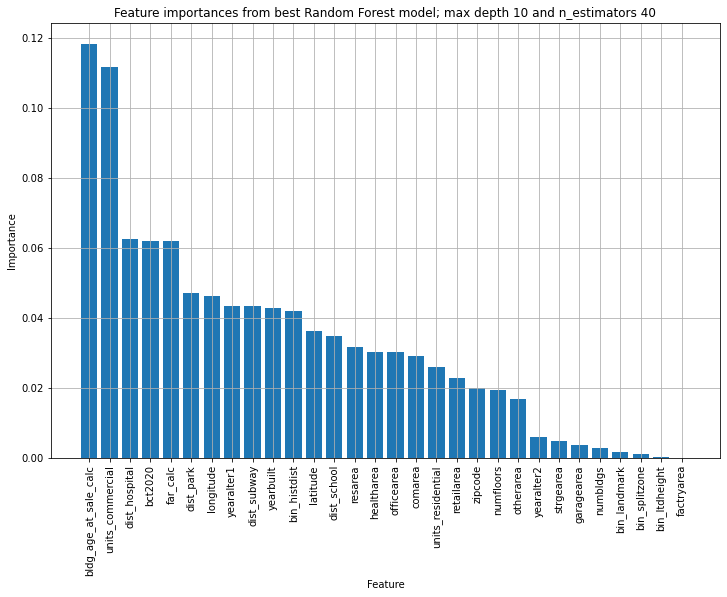

In [14]:
import matplotlib.pyplot as plt
best_forest = RandomForestRegressor(max_depth = grid.best_params_['max_depth'], n_estimators=grid.best_params_['n_estimators']).fit(preprocessor_full_rf(X_train), y_train)

forest_1_predictions = best_forest.predict(preprocessor_full_rf(X_test))

feature_names = X_train.columns
forest_importances = pd.DataFrame(best_forest.feature_importances_, index=feature_names).sort_values([0], ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(forest_importances.index, forest_importances[0])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature importances from best Random Forest model; max depth {} and n_estimators {}'.format(
    grid.best_params_['max_depth'], grid.best_params_['n_estimators']))
plt.grid()
plt.savefig('Data/OUTPUT_models/featureimportances.png')
plt.show()

In [15]:
most_imp_cols = forest_importances.index[:20]

X_train_imp = X_train[most_imp_cols]
X_test_imp = X_test[most_imp_cols]

### RF preprocessor, subset

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features_sub = X_train_imp.select_dtypes([np.number]).columns.tolist()
categorical_features_sub = X_train_imp.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

preprocessor_sub_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_sub),
        ('cat', categorical_transformer, categorical_features_sub)])

preprocess_sub_rf = preprocessor_sub_rf.fit(X_train_imp) 

def preprocessor_sub_rf(data):
    preprocessed_data = preprocess_sub_rf.transform(data)
    return preprocessed_data

#### RF, subset

In [18]:
rf = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'], max_depth=grid.best_params_['max_depth']).fit(preprocessor_sub_rf(X_train_imp), y_train)
#param_grid = {'max_depth': [10, 15, 20, 25],
              #'n_estimators': [10, 30, 50, 100]}
#grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, cv=10)

print("Train set score: {:.5f}".format(rf.score(preprocessor_sub_rf(X_train_imp), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(rf, preprocessor_sub_rf(X_train_imp), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(rf.score(preprocessor_sub_rf(X_test_imp), y_test)))

forest_2_predictions = rf.predict(preprocessor_sub_rf(X_test_imp))

Train set score: 0.40664
Mean cross-val score for train set: 0.14289
Test set score: 0.22176.


### OLS preprocessor, full model

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
import numpy as np

#turn columns into categorical variables: zip code, police precinct, school district, etc.
#ENSURE COLS ARE OHE: ['policeprct', 'schooldist', 'healthcenterdistrict', 'sanitdistrict', 'council']

numeric_features_full = X_train.select_dtypes([np.number]).columns.tolist()

categorical_features_full = X_train.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_full_ols = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_full),
        ('cat', categorical_transformer, categorical_features_full)])

preprocessor_full_lr = preprocessor_full_ols.fit(X_train) 

def preprocessor_full_ols(data):
    preprocessed_data = preprocessor_full_lr.transform(data)
    return preprocessed_data

#### OLS, full model

Train set score: 0.07146
Mean cross-val score for train set: 0.02317
Test set score: -0.27778.


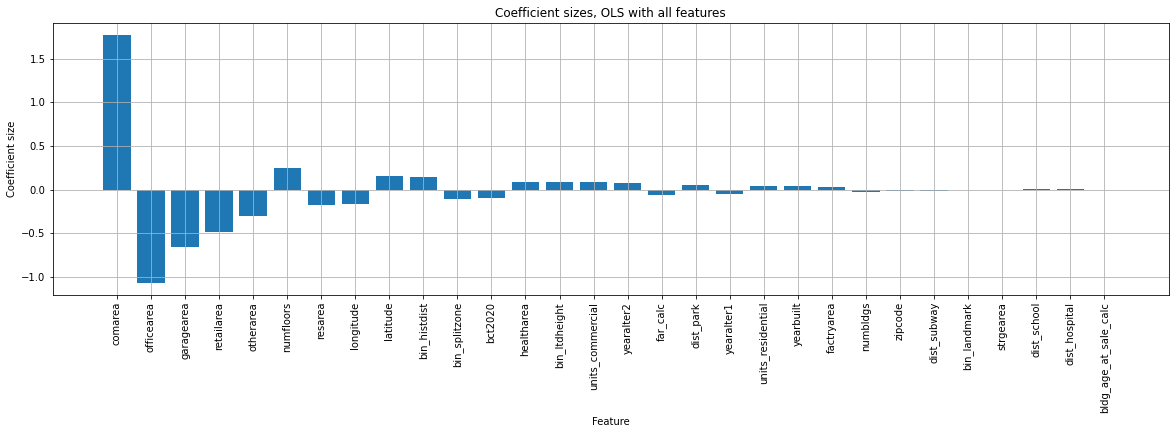

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(preprocessor_full_ols(X_train), y_train)

print("Train set score: {:.5f}".format(lr.score(preprocessor_full_ols(X_train), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(lr, preprocessor_full_ols(X_train), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(lr.score(preprocessor_full_ols(X_test), y_test)))

ols_1_predictions = lr.predict(preprocessor_full_ols(X_test))

#sort results by coefficient size
ols_1_results = pd.concat((pd.DataFrame(X_train.columns), pd.DataFrame(lr.coef_)), axis=1)
ols_1_results.columns = ['column', 'coef']
ols_1_results = ols_1_results.sort_values('coef', ascending=False, key=abs)

#plot figure
plt.figure(figsize=(20, 5))
plt.bar(ols_1_results.column, ols_1_results.coef)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Feature")
plt.ylabel('Coefficient size')
plt.title('Coefficient sizes, OLS with all features')
plt.savefig("Data/OUTPUT_models/fullolscoefs.png")
plt.show()

### OLS preprocessor, subset

In [31]:
numeric_features_sub = X_train_imp.select_dtypes([np.number]).columns.tolist()
categorical_features_sub = X_train_imp.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess_sub_ols = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_sub),
        ('cat', categorical_transformer, categorical_features_sub)])

preprocess_sub_lr = preprocess_sub_ols.fit(X_train_imp) 

def preprocessor_sub_ols(data):
    preprocessed_data = preprocess_sub_lr.transform(data)
    return preprocessed_data

#### OLS, subset

Train set score: 0.05206
Mean cross-val score for train set: 0.00225
Test set score: 0.09926.


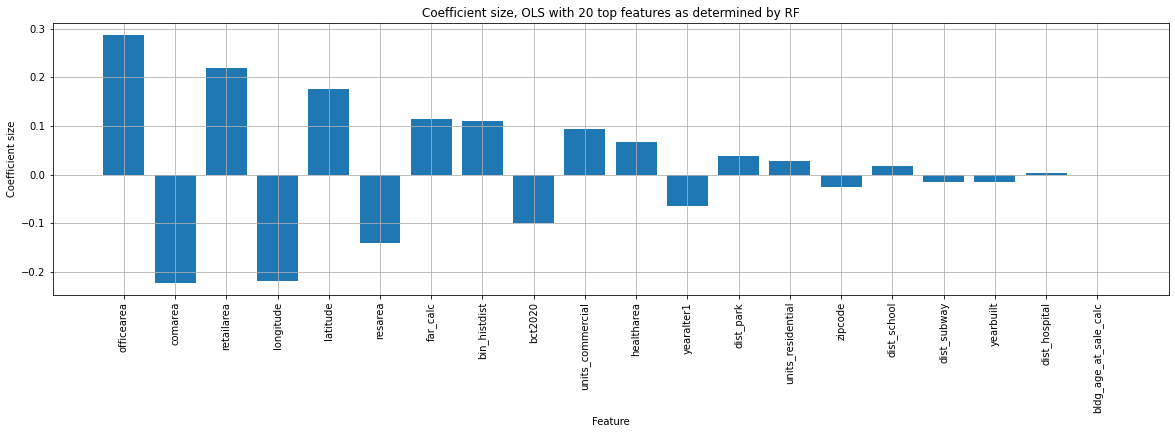

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(preprocessor_sub_ols(X_train_imp), y_train)

print("Train set score: {:.5f}".format(lr.score(preprocessor_sub_ols(X_train_imp), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(lr, preprocessor_sub_ols(X_train_imp), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(lr.score(preprocessor_sub_ols(X_test_imp), y_test)))

ols_2_predictions = lr.predict(preprocessor_sub_ols(X_test_imp))

#sort results by coefficient size
ols_2_results = pd.concat((pd.DataFrame(X_train_imp.columns), pd.DataFrame(lr.coef_)), axis=1)
ols_2_results.columns = ['column', 'coef']
ols_2_results = ols_2_results.sort_values('coef', ascending=False, key=abs)

#plot figure
plt.figure(figsize=(20, 5))
plt.bar(ols_2_results.column, ols_2_results.coef)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Feature")
plt.ylabel('Coefficient size')
plt.title('Coefficient size, OLS with 20 top features as determined by RF')
plt.savefig("Data/OUTPUT_models/subsetcoefs.png")
plt.show()

## Compare models

In [35]:
results = pd.DataFrame()
results['Model'] = ['RF, all features', 'RF, 20 features', 'OLS, all features', 'OLS, 20 features']
results = results.set_index('Model')

from sklearn.metrics import mean_squared_error
import math

#RMSE AND %RMSE
results['RMSE'] = [math.sqrt(mean_squared_error(forest_1_predictions, y_test)), 
                  math.sqrt(mean_squared_error(forest_2_predictions, y_test)), 
                  math.sqrt(mean_squared_error(ols_1_predictions, y_test)), 
                  math.sqrt(mean_squared_error(ols_2_predictions, y_test))]

def percent_rmse(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
    return rmspe
results['%RMSE'] = [percent_rmse(y_test, forest_1_predictions),
                   percent_rmse(y_test, forest_2_predictions),
                   percent_rmse(y_test, ols_1_predictions),
                   percent_rmse(y_test, ols_2_predictions)]

#MAE AND MAPE
from sklearn.metrics import mean_absolute_error
results['MAE'] = [mean_absolute_error(y_test, forest_1_predictions).round(2), 
                  mean_absolute_error(y_test, forest_2_predictions), 
                  mean_absolute_error(y_test, ols_1_predictions), 
                  mean_absolute_error(y_test, ols_2_predictions)]

def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

results['%MAE'] = [MAPE(y_test, forest_1_predictions),
                   MAPE(y_test, forest_2_predictions),
                   MAPE(y_test, ols_1_predictions),
                   MAPE(y_test, ols_2_predictions)]

#R2 (COEFFICIENT OF DETERMINATION)
from sklearn.metrics import r2_score
results['R-squared'] = [r2_score(y_test, forest_1_predictions), 
                  r2_score(y_test, forest_2_predictions), 
                  r2_score(y_test, ols_1_predictions), 
                  r2_score(y_test, ols_2_predictions)]

results = results.round(3)
results

,RMSE,%RMSE,MAE,%MAE,R-squared
Model,,,,,
"RF, all features",1.306,inf,0.730,inf,0.231
"RF, 20 features",1.314,inf,0.722,inf,0.222
"OLS, all features",1.684,inf,1.129,inf,-0.278
"OLS, 20 features",1.414,inf,0.851,inf,0.099


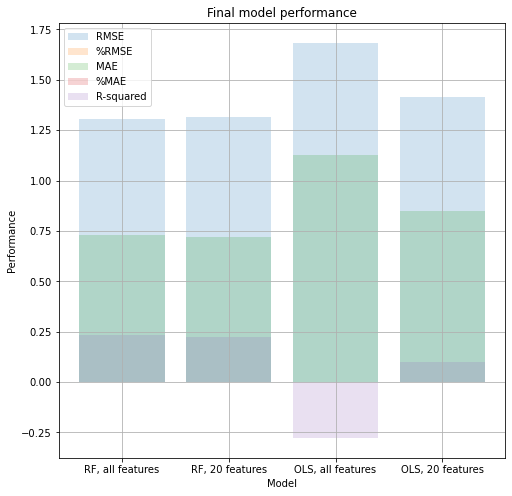

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for i in results.columns:
    plt.bar(results.index, results[i], label=i, alpha=0.2)
plt.legend()
plt.xlabel('Model')
plt.ylabel('Performance')
plt.title('Final model performance')
plt.savefig('Data/OUTPUT_models/model_performance.png')
plt.grid()
plt.show()

In [38]:
#hit rates
y_test_for_hit_rate = list(y_test)
hit_rates = pd.DataFrame(index=['RF, all features', 'RF, 20 features', 'OLS, all features', 'OLS, 20 features'], 
                         columns=['Within 1%', 'Within 5%', 'Within 10%'])
predictions = [forest_1_predictions, forest_2_predictions, ols_1_predictions, ols_2_predictions]
def predict_hit_rate(y_true, y_pred, margin):
    a = 0
    rate_tmp = []
    for i in y_pred:
        if i >= y_true.iloc[a]*(1-margin):
            if i >= y_true.iloc[a]*(1+margin):
                rate_tmp.append(1)
            else:
                pass
        else:
            rate_tmp.append(0)
        a += 1
    return(sum(rate_tmp) / len(rate_tmp))

hit_rates['Within 1%']['RF, all features'] = predict_hit_rate(y_test, forest_1_predictions, 0.01)*100
hit_rates['Within 1%']['RF, 20 features'] = predict_hit_rate(y_test, forest_2_predictions, 0.01)*100
hit_rates['Within 1%']['OLS, all features'] = predict_hit_rate(y_test, ols_1_predictions, 0.01)*100
hit_rates['Within 1%']['OLS, 20 features'] = predict_hit_rate(y_test, ols_2_predictions, 0.01)*100
hit_rates['Within 5%']['RF, all features'] = predict_hit_rate(y_test, forest_1_predictions, 0.05)*100
hit_rates['Within 5%']['RF, 20 features'] = predict_hit_rate(y_test, forest_2_predictions, 0.05)*100
hit_rates['Within 5%']['OLS, all features'] = predict_hit_rate(y_test, ols_1_predictions, 0.05)*100
hit_rates['Within 5%']['OLS, 20 features'] = predict_hit_rate(y_test, ols_2_predictions, 0.05)*100
hit_rates['Within 10%']['RF, all features'] = predict_hit_rate(y_test, forest_1_predictions, 0.10)*100
hit_rates['Within 10%']['RF, 20 features'] = predict_hit_rate(y_test, forest_2_predictions, 0.10)*100
hit_rates['Within 10%']['OLS, all features'] = predict_hit_rate(y_test, ols_1_predictions, 0.10)*100
hit_rates['Within 10%']['OLS, 20 features'] = predict_hit_rate(y_test, ols_2_predictions, 0.10)*100

hit_rates.astype(float).round(3)

,Within 1%,Within 5%,Within 10%
"RF, all features",53.867,54.136,55.109
"RF, 20 features",53.296,52.705,55.467
"OLS, all features",60.177,63.184,71.504
"OLS, 20 features",49.349,43.482,39.687


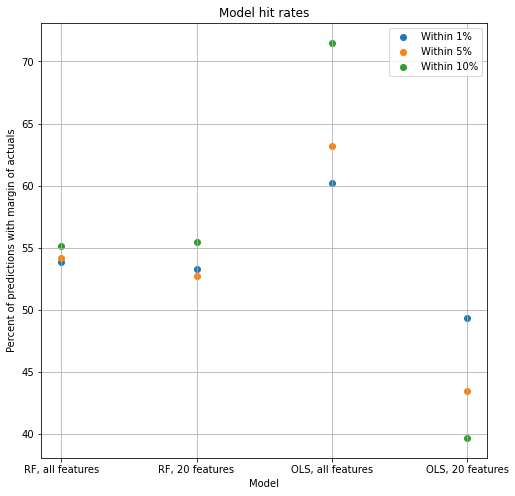

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in hit_rates.columns:
    plt.scatter(hit_rates.index, hit_rates[i], label=i)
plt.legend()
plt.xlabel('Model')
plt.ylabel('Percent of predictions with margin of actuals')
plt.title('Model hit rates')
plt.savefig('Data/OUTPUT_models/hit_rates.png')
plt.grid()
plt.show()